# Glaze et al (2015): Normative evidence accumulation in unpredictable environments

# Recap

Last session we saw what a continous, integrating model looks like. The drift diffusion model (DDM) takes into account a drift parameter along with previous data (finish the clause). The Ornstein-Uhlenbeck (O-U) model extended the pure DDM with anothe free parameter to "leak" previously seen data, effectively giving the model memory.

Glaze et al. (2015) reintroduces volatility into the model while extending on this leaky accumulation concept. Additionally, the Glaze model introduces non-absorbing bounds, so that hazard rate can change intra-task and can be evaluated contiunously and in real-time. The DDM and O-U models "stop" once the accumulation hits a pre-defined bound, while the Glaze model asymptotically accumulates the new information.

## Model Comparison

|Feature|Pure DDM|O-U|Glaze|
|---|---|---|---|
|Accumulation|Perfect Integration|Leaky Integration|Adaptive (Leaky -> Stable)|
|Key Parameter|Drift (A)|Leak (lambda) + Drift (A)|Hazard Rate (H)|
|Boundaries|Absorbing (Stop)|Absorbing (Stop)|Non-Absorbing (Monitor)|
|Handling Volatility|Fails (Integrates noise)|Constant Leak (Fixed adaptation)|Dynamic Leak (Adapts to H)|

# Getting Started

## Install Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate synthetic data

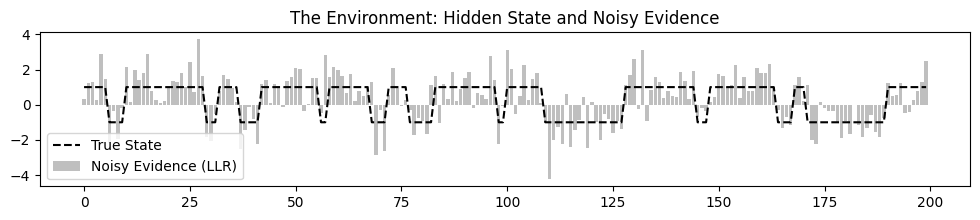

In [2]:
# --- 1. Generate Synthetic Data (The Environment) ---
np.random.seed(42)
n_trials = 200
H_true = 0.1  # The "Objective Hazard Rate" (Probability of switch per trial)
noise_std = 1.0

# Generate true state (1 or -1) switching with probability H
true_state = np.zeros(n_trials)
current_state = 1
for t in range(n_trials):
    if np.random.rand() < H_true:
        current_state *= -1 # Switch state
    true_state[t] = current_state

# Generate noisy sensory evidence (Log Likelihood Ratios - LLR)
# In this simulation, positive LLR supports state 1, negative LLR supports state -1
# This assumes Gaussian noise around the signal.
evidence = np.random.normal(loc=true_state, scale=noise_std)
LLR = evidence  # Simplified: assuming LLR is proportional to raw evidence

# Plot the environment
plt.figure(figsize=(12, 2))
plt.plot(true_state, label='True State', color='black', linestyle='--')
plt.bar(range(n_trials), LLR, color='gray', alpha=0.5, label='Noisy Evidence (LLR)')
plt.title("The Environment: Hidden State and Noisy Evidence")
plt.legend()
plt.show()

# The Baseline Glaze Model (Perfect Accumulator)

$$ L_n = L_{n-1} + LLR_n $$

This represents perfect integration where $ H = 0 $.

In [3]:
def perfect_accumulator(llrs):
    """
    Standard Drift Diffusion / Perfect Integration.
    Assumes H = 0 (Stability).
    """
    n = len(llrs)
    L = np.zeros(n)

    for t in range(1, n):
        # The Update Rule: Simple addition of new evidence
        L[t] = L[t-1] + llrs[t]

    return L

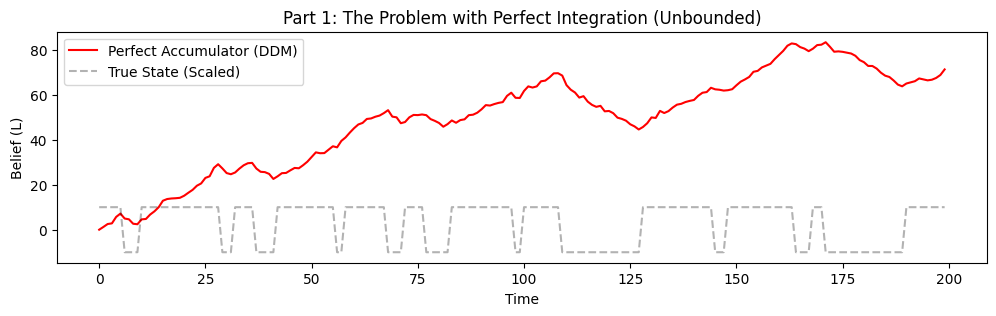

In [4]:
L_perfect = perfect_accumulator(LLR)

plt.figure(figsize=(12, 3))
plt.plot(L_perfect, label='Perfect Accumulator (DDM)', color='red')
plt.plot(true_state * 10, 'k--', label='True State (Scaled)', alpha=0.3) # Scaled for visibility
plt.title("Part 1: The Problem with Perfect Integration (Unbounded)")
plt.ylabel("Belief (L)")
plt.xlabel("Time")
plt.legend()
plt.show()

# The Discrete Model (Perfect Accumulation)

$$ L_n = \psi(L_{n-1}, H) + LLR_n $$

The Prior expectation function $\psi$ transforms the previous belief based on the hazard rate before adding new evidence.

$$ \psi(L_{n-1}, H) = L_{n-1} + \log\left(\frac{1-H}{H} + \exp(-L_{n-1})\right) - \log\left(\frac{1-H}{H} + \exp(L_{n-1})\right) $$


In [5]:
def psi_function(L_prev, H):
    """
    The non-linear prior expectation function from Glaze et al. (2015).
    This function distorts the previous belief based on the hazard rate.
    """
    # Prevent numerical overflow for very large L
    # If L is huge, the prior is just the bound (see Part 3)
    if abs(L_prev) > 100:
        return np.sign(L_prev) * np.log((1-H)/H)

    # The Exact Equation (Eq 2 in Glaze 2015)
    term1 = (1 - H) / H
    term_pos = term1 + np.exp(-L_prev)
    term_neg = term1 + np.exp(L_prev)

    return L_prev + np.log(term_pos) - np.log(term_neg)

def glaze_model(llrs, H):
    n = len(llrs)
    L = np.zeros(n)

    for t in range(1, n):
        # 1. Calculate Prior Expectation (The "Psi" function)
        prior = psi_function(L[t-1], H)

        # 2. Update with new evidence
        L[t] = prior + llrs[t]

    return L

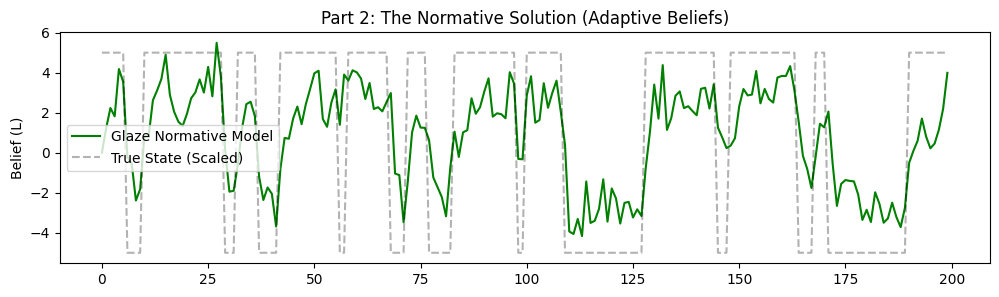

In [6]:
L_glaze = glaze_model(LLR, H=0.1)

plt.figure(figsize=(12, 3))
plt.plot(L_glaze, label='Glaze Normative Model', color='green')
plt.plot(true_state * 5, 'k--', label='True State (Scaled)', alpha=0.3)
plt.title("Part 2: The Normative Solution (Adaptive Beliefs)")
plt.ylabel("Belief (L)")
plt.legend()
plt.show()

# Approximations

## Leaky Accumulation (Low Certainty)

When the belief L is close to 0 (uncertain), the model acts like a linear leaky accumulator.

$$ \psi(L_{n-1}, H) \approx (1 - 2H) \cdot L_{n-1} \quad \text{for} \quad L_{n-1} \approx 0 $$

## Stabilizing Bound (High Certainty)

When the belief L is strong, the prior saturates at a specific bound determined by the hazard rate.

$$ \psi(L_{n-1}, H) \approx \text{sgn}(L_{n-1}) \log\left(\frac{1-H}{H}\right) \quad \text{for} \quad |L_{n-1}| \gg 0 $$

<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1018261996.py:28: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(L_prev_range, psi_values, 'g-', linewidth=3, label='Normative Prior ($\psi$)')
/tmp/ipython-input-1018261996.py:37: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("Prior Expectation ($\psi$)")


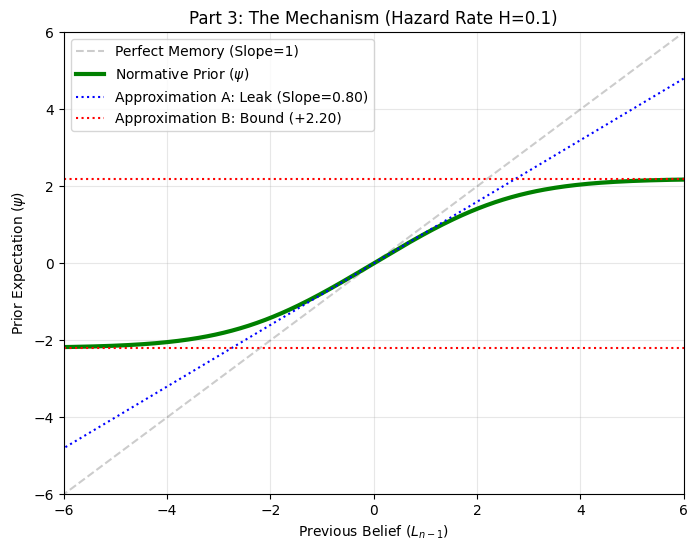

In [7]:
def plot_update_dynamics(H):
    """
    Visualizes the Psi function against the approximations
    to teach 'Leak' vs 'Bound'.
    """
    # Create a range of previous beliefs (from very negative to very positive)
    L_prev_range = np.linspace(-10, 10, 500)

    # 1. Calculate the full Normative update (Psi)
    psi_values = [psi_function(l, H) for l in L_prev_range]

    # 2. Approximation A: The Linear Leak (Slope < 1)
    # Equation: (1 - 2H) * L
    leak_slope = (1 - 2 * H)
    leak_values = leak_slope * L_prev_range

    # 3. Approximation B: The Stabilizing Bound (Asymptote)
    # Equation: log((1-H)/H)
    bound_value = np.log((1 - H) / H)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Plot Identity line (Perfect Accumulator) for comparison
    plt.plot(L_prev_range, L_prev_range, 'k--', alpha=0.2, label='Perfect Memory (Slope=1)')

    # Plot Normative Psi
    plt.plot(L_prev_range, psi_values, 'g-', linewidth=3, label='Normative Prior ($\psi$)')

    # Plot Approximations
    plt.plot(L_prev_range, leak_values, 'b:', label=f'Approximation A: Leak (Slope={leak_slope:.2f})')
    plt.axhline(bound_value, color='r', linestyle=':', label=f'Approximation B: Bound (+{bound_value:.2f})')
    plt.axhline(-bound_value, color='r', linestyle=':')

    plt.title(f"Part 3: The Mechanism (Hazard Rate H={H})")
    plt.xlabel("Previous Belief ($L_{n-1}$)")
    plt.ylabel("Prior Expectation ($\psi$)")
    plt.ylim(-6, 6)
    plt.xlim(-6, 6)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the visualization
plot_update_dynamics(H=0.1)

# The Continuous Glaze Model

$$ dL(t) = \left[ -2\lambda \sinh(L(t)) \right] dt + A dx(t) $$

In [8]:
def continuous_glaze_model(evidence_stream, lambda_rate, dt=0.01):
    """
    Continuous time implementation using Euler integration.
    lambda_rate: The change rate (hazard rate in continuous time)
    """
    n_steps = len(evidence_stream)
    L = np.zeros(n_steps)

    for t in range(1, n_steps):
        # Previous state
        L_prev = L[t-1]

        # The Non-linear "Filter" Term (Leak + Bound dynamics)
        # Equation: -2 * lambda * sinh(L)
        deterministic_change = -2 * lambda_rate * np.sinh(L_prev) * dt

        # New evidence (Drift + Noise)
        # Note: In discrete simulation, 'evidence_stream' represents A*dx
        new_evidence = evidence_stream[t] * dt

        # Update
        L[t] = L_prev + deterministic_change + new_evidence

    return L

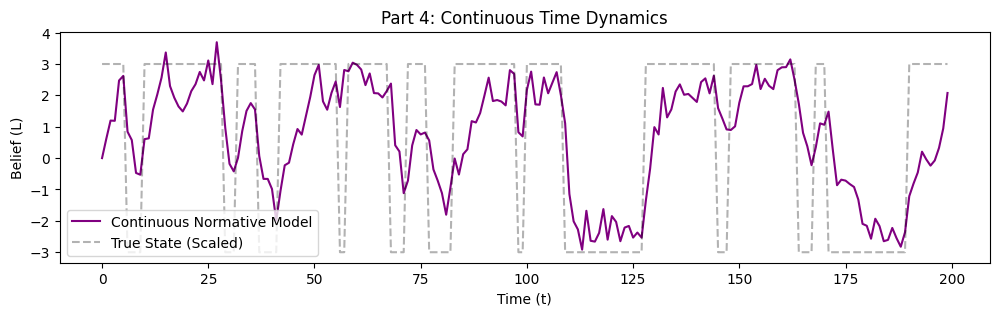

In [9]:
L_continuous = continuous_glaze_model(evidence, lambda_rate=0.1, dt=0.5)

plt.figure(figsize=(12, 3))
plt.plot(L_continuous, label='Continuous Normative Model', color='purple')
plt.plot(true_state * 3, 'k--', label='True State (Scaled)', alpha=0.3)
plt.title("Part 4: Continuous Time Dynamics")
plt.xlabel("Time (t)")
plt.ylabel("Belief (L)")
plt.legend()
plt.show()